# Tutorial on PINN and motivations for MINN

<small> &copy; Written by Yicun Huang and Changfu Zou
from automatic control group, Electrical Engineering, Chalmers University of Technology, Gothenburg, Sweden.

Emails: yicun@chalmers.se and changfu.zou@chalmers.se

This tutorial is created for implementing a simple 1D battery thermal model. 

### Existing Packages

+ NeuralPDE
+ DeepXDE
+ SimNet
+ pytorch

### Libraries

In [2]:
! pip install pyDOE
! pip install torch
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from sklearn.model_selection import train_test_split

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generators
torch.manual_seed(1234)
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda':
    print(torch.cuda.get_device_name())


cpu


# Neural Network (NN): Introduction

### Definition

Taking a feed-forward NN with two hidden layers as an example, the relationship between input (X) and output (Y) is defined as:

$$\text{NN}(X) = \sigma_3\Bigg(W_3\sigma_2\Big(W_2\sigma_1(W_1X + b_1) + b_2\Big) + b_3\Bigg)
$$

where $\sigma_i$ are the activation functions.

**Note:** $((W_i,b_i))$ are the parameters of $NN(X)$. 

In [3]:
class FCN(nn.Module):
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class
        'activation function'
        self.activation = nn.Tanh() 
        
        'Initialization'
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.iter = 0 #For the Optimizer
        'Xavier Normal Initialization'
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)

    'forward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:
            x = torch.from_numpy(x)
        a = x.float()
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = self.activation(z)
        a = self.linears[-1](a)
        return a

**Questions**
- How to make $NN(X)$ sufficiently smooth (i.e. finite 1st and 2nd order derivatives)?
- How to impose constraints on NN(X)?

# Why Neural network?

Finding the weights and biases that make NN(X) act like a function $y(X)$, where $y(X)$ represents the ground truth.


### Universal Approximation Theorem

For any ϵ of accuracy, if your neural network is sufficiently large (sufficiently many hidden layers, and sufficiently large weight matrices), NN(X) can approximate any functions within error ϵ.

### Classical approximations: 
- $F(X; \theta) = a_0 + a_1 X + a_2 X^2 + \ldots$, $\theta := a_i$
- $F(X; \theta) = a_0 + \sum_k [b_k \cos(kX) + c_k \sin(kX)]$, $\theta := [a_0\,\, b_k\,\, c_k]$

### In higher dimension

$$y(X_i)\approx \bigotimes_{i = 1}^{d} F(X_i)$$

approximates a function $y$ of dimension d 

This means that if we use $n$ coefficients in each dimension $i$ in $d$, the total number of coefficients needed to approximate a d-dimensional function one-dimensional $F(X)$ would need $n^d$ coefficients. This exponential growth is known as the **curse of dimensionality**.


# Problem statement
Consider a 1D heat equation with a time-varying sink, where $y$ is the temperature, $x$ is the thickness and $t$ is time.

### PDE ###

$$\frac{\partial y}{\partial t} =\alpha\frac{\partial^2 y}{\partial x^2}-e^{-t}(sin(\pi x)-\pi^2 sin(\pi x))$$

### Parameter
$$\alpha = 1$$

### Nondimensionalization

$$x\in[-1,1]$$
$$t\in[0,1]$$

In [4]:
x_min=-1
x_max=1
t_min=0
t_max=1

### Initial condition (IC):

$$y(x,0)=sin(\pi x)$$

### Boundary conditions (BCs):

$$y(-1,t)=0$$
$$y(1,t)=0$$

# Automatic Diffrentiation (AD)
Since $NN(X)$ is a function where $X=[t,\,x]^{T}$ is the input, we can obtain its derivatives: $\frac{\partial NN}{\partial t},\,\frac{\partial NN}{\partial x}$ and $\frac{\partial^2 NN}{\partial x^2}$ using:

+ numerical differentiation
+ automatic differentiation (AD)
+ advantage of AD over numerical integration


### Creating $NN(X)$

Assuming $NN(t,x)\approx y$, we approximate the function y(X): R2→R1, i.e. two inputs and one output. 


In [5]:
layers = np.array([2,32,32,1])
FCN(layers)

FCN(
  (activation): Tanh()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)

### Rearranging:

$$\left(\frac{\partial y}{\partial t} -\frac{\partial^2 y}{\partial x^2}\right)+e^{-t}(sin(\pi x)-\pi^2 sin(\pi x))=0$$

We define a function $\hat{f}$:

$$\hat{f}(t,x)=\left(\frac{\partial NN}{\partial t} -\frac{\partial^2 NN}{\partial x^2}
\right)+e^{-t}(sin(\pi x)-\pi^2 sin(\pi x))$$

If $\hat{f}\rightarrow 0$ then $NN(X)\approx y(X)$.

### PINNs' Loss function

Now we train our NN(X) by iteratively minimizing a loss function. To this end, our PDE is first evaluated on the "collocation points" ($N_{f}$) inside our domain $(x,t)$ to obtain the PDE loss:

$$MSE_{PDE}=\frac{1}{N_f}\sum^{N_f}_{i=1}|f(t_f^i,x_f^i)|^2$$

Note  = number of data samples for training.


In [6]:
def lossPDE(self,x_PDE):
    g=x_PDE.clone()
    g.requires_grad=True #Enable AD
    f=self.forward(g)
    f_x_t = autograd.grad(f,g,torch.ones([g.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
    f_xx_tt = autograd.grad(f_x_t,g,torch.ones(g.shape).to(device), create_graph=True)[0]
    f_t=f_x_t[:,[1]]
    f_xx=f_xx_tt[:,[0]]
    f_hat=f_t-f_xx+ torch.exp(-g[:, 1:])* (torch.sin(np.pi * g[:, 0:1]) - np.pi ** 2 * torch.sin(np.pi * g[:, 0:1]))
    return self.loss_function(f_hat,f)

## Key observations

Capability of PINNs: Learn the fixed solution, namely the solution of an autonomous system, or of a non-autonomous system at a given input profile and a given initial state.


## Limitations

* When the input profile/initial state is changed, one has to re-train the model of PINNs.
* When the input profile/initial state is dynamically changed, one has to train PINNs online at each time step, which is almost impossible in real-time control systems. 


# Model integrated neural networks (MINN)

For a non-autonomous system (e.g. for battery cooling control purposes), such that the function $f(t_f^i,x_f^i,u^i)$ includes a control input $u$ which is time-varying, PINNs will not work because it only approximates the solution trajectory of a pre-defined (fixed) input. Under such applications, one has to resort to the MINN formulation, which learns the dynamics of a non-autonomous system. It can be found in the paper: 

MINN: Learning the dynamics of differential-algebraic equations and application to battery modeling. ArXiv preprint https://arxiv.org/abs/2304.14422

### Key advantage of MINN over PINN
* Learning the dynamics of a non-autonomous system, as opposed to a fixed solution of an autonomous system with predefined initial and boundary conditions.

# Implementations

### Discreatization

In [7]:
N_points_x=200
total_points_t=100

# Create equally spaced discreatization in x and t 
x=torch.linspace(x_min,x_max,N_points_x).view(-1,1)
t=torch.linspace(t_min,t_max,total_points_t).view(-1,1)

# Create the mesh
X,T=torch.meshgrid(x.squeeze(1),t.squeeze(1))

# Domain bounds
lb = torch.tensor([-1.,  0.]) #x, t
ub = torch.tensor([1., 1.]) #x, t

C:\Users\adamb\anaconda3\envs\lab2\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\b\abs_abjetg6_iu\croot\pytorch_1686932924616\work\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


We can then generate the training dataset using the known exact solution, i.e.,

$y(x,t)=e^{-t}\sin(\pi x)$.

In [8]:
def f_data(x,t):
  return torch.exp(-t)*(torch.sin(np.pi*x))

### Let's plot the data (ground truth)

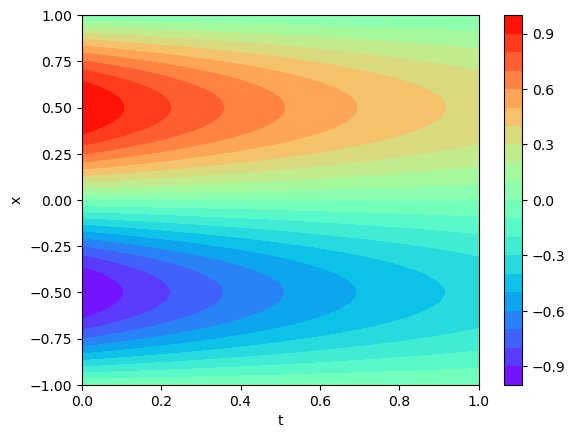

In [9]:
y_exact=f_data(X,T)

def plot_data(X,T,y):
  fig,ax=plt.subplots(1,1)
  cp = ax.contourf(T,X, y,20,cmap="rainbow")
  fig.colorbar(cp) # Add a colorbar to a plot
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  plt.show()
 
plot_data(X,T,y_exact)

### Generating collocations points for PDE loss using Latin hypercube sampling

In [10]:
X_train_Nf=lb+(ub-lb)*lhs(2,10000) # two inputs and 10000 collocation points

### Generating BCIC training data

Similarly, we obtain the training dataset from the known boundary and initial conditions (BCICs).

#### Initial Condition:

$$y(x,0)=sin(\pi x)$$

#### Boundary Conditions:

$$y(-1,t)=0$$
$$y(1,t)=0$$

In [11]:
# Initial Condition

# Left Edge: y(x,0) = sin(x) at t=0
# [:,None] is to give it the right dimension
left_X=torch.hstack((X[:,0][:,None],T[:,0][:,None])) # First column
left_Y=torch.sin(np.pi*left_X[:,0]).unsqueeze(1)

#Boundary Conditions

#Bottom Edge: x = -1
bottom_X=torch.hstack((X[0,:][:,None],T[0,:][:,None])) # First row
bottom_Y=torch.zeros(bottom_X.shape[0],1)

#Top Edge: x= 1
top_X=torch.hstack((X[-1,:][:,None],T[-1,:][:,None])) # Last row
top_Y=torch.zeros(top_X.shape[0],1)

#Collect all the training data into the same dataset
X_train=torch.vstack([left_X,bottom_X,top_X])
Y_train=torch.vstack([left_Y,bottom_Y,top_Y])

#Select 100 random points from the initial and boundary data:
idx=np.random.choice(X_train.shape[0],100,replace=False)
X_train_Nu=X_train[idx,:]
Y_train_Nu=Y_train[idx,:]

#Adding all up to form the training data for X
X_train_Nf=torch.vstack((X_train_Nf,X_train_Nu)) 

$$MSE_{BCICs}=\frac{1}{N_{BCICs}}\sum^{N_{BCICs}}_{i=1}\Big|y(t_{BCICs}^i,x_{BCICs}^i)-NN(t_{BCICs}^i,x_{BCICs}^i)\Big|^2$$


#### Total Loss:

$$MSE_{PINN}=MSE_{PDE}+MSE_{BCIC}$$

### Wrapping up things together

In [12]:
class FCN(nn.Module):
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class
        'activation function'
        self.activation = nn.Tanh()
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        'Initialise neural network as a list using nn.Modulelist'
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.iter = 0 #For the Optimizer
        'Xavier Normal Initialization'
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)

    'foward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:
            x = torch.from_numpy(x)
        a = x.float()
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = self.activation(z)
        a = self.linears[-1](a)
        return a

    'Loss Functions'
    # Boundary loss
    def lossBC(self,x_BC,y_BC):
      loss_BC=self.loss_function(self.forward(x_BC),y_BC)
      return loss_BC

    # PDE loss
    def lossPDE(self,x_PDE):
        g=x_PDE.clone()
        g.requires_grad=True #Enable AD
        f=self.forward(g)
        f_x_t = autograd.grad(f,g,torch.ones([g.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        f_xx_tt = autograd.grad(f_x_t,g,torch.ones(g.shape).to(device), create_graph=True)[0]
        f_t=f_x_t[:,[1]]
        f_xx=f_xx_tt[:,[0]]
        f_hat=f_t-f_xx+ torch.exp(-g[:, 1:])* (torch.sin(np.pi * g[:, 0:1]) - np.pi ** 2 * torch.sin(np.pi * g[:, 0:1]))
        return self.loss_function(f_hat,f)

    def loss(self,x_BC,y_BC,x_PDE):
      loss_bc=self.lossBC(x_BC,y_BC)
      loss_pde=self.lossPDE(x_PDE)
      return loss_bc+loss_pde

# Training

In [13]:
torch.manual_seed(123)
#Uploading training data to GPU
X_train_Nu=X_train_Nu.float().to(device) 
Y_train_Nu=Y_train_Nu.float().to(device) 
X_train_Nf=X_train_Nf.float().to(device) 

#Create Model
PINN = FCN(layers)
PINN.to(device)
print(PINN)
params = list(PINN.parameters())
optimizer = torch.optim.Adam(PINN.parameters(),lr=1e-3,amsgrad=False)
start_time = time.time()


FCN(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [16]:
steps = 200
for i in range(steps):
    if i==0:
      print("Training Loss")
    loss = PINN.loss(X_train_Nu,Y_train_Nu,X_train_Nf)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i%(steps/10)==0:
      with torch.no_grad():
          print(loss.detach().cpu().numpy())

Training Loss
0.2681733
0.23051077
0.19306047
0.1572787
0.12644675
0.10343267
0.08792034
0.07648169
0.06629591
0.056293346


# Testing

In [17]:
x_test=torch.hstack((X.transpose(1,0).flatten()[:,None],T.transpose(1,0).flatten()[:,None]))
y_test=y_exact.transpose(1,0).flatten()[:,None] 

In [18]:
y1 = PINN(x_test)
x1 = x_test[:,0]
t1 = x_test[:,1]

In [19]:
arr_x1=x1.reshape(shape=[100,200]).transpose(1,0).detach().cpu()
arr_T1=t1.reshape(shape=[100,200]).transpose(1,0).detach().cpu()
arr_y1=y1.reshape(shape=[100,200]).transpose(1,0).detach().cpu()
arr_y_test=y_test.reshape(shape=[100,200]).transpose(1,0).detach().cpu()

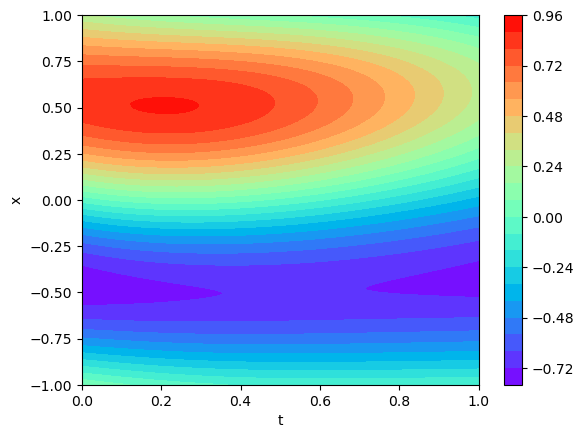

In [20]:
plot_data(arr_x1,arr_T1,arr_y1)

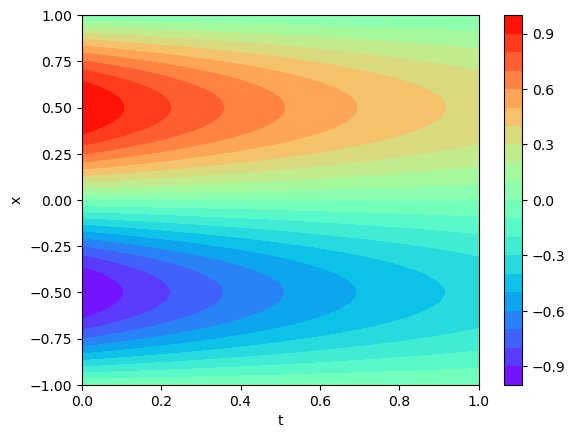

In [21]:
plot_data(X,T,y_exact)

## References:


[1] Raissi, M., Perdikaris, P., & Karniadakis, G. E. (2017). Physics informed deep learning (part i): Data-driven solutions of nonlinear partial differential equations. ArXiv preprint arXiv:1711.10561. http://arxiv.org/pdf/1711.10561v1

[2] Lu, L., Meng, X., Mao, Z., & Karniadakis, G. E. (1907). DeepXDE: A deep learning library for solving differential equations,(2019). ArXiv preprint https://arxiv.org/abs/1907.04502

[3] Huang, Y. and Zou, C. and Li, Y. and Wik, T. (2023). MINN: Learning the dynamics of differential-algebraic equations and application to battery modeling. ArXiv preprint https://arxiv.org/abs/2304.14422



# Exercise

+ Plot the testing error 
+ Minimize the testing error 

**Hint:** use the L-BFGS Optimizer
+ Set up an inverse problem to infer the parameter $\alpha$

+ Train a MINN model using for a surface cooled battery , i.e.,

$$y(x,0)=u(t)$$